### Step 0: Importing libraries

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import tensorflow as tf
import keras
from keras import layers

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

### Step 1: Reading dataset

In this project I will use a loan approvement dataset, which describes a person's financial situation, the amount of loan they have taken, and if it has been approved or not.

In [54]:
df = pd.read_csv("loan_approval.csv")
df.head()

,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,Allison Hill,East Jill,113810,389,39698,27,50.0,False
1,Brandon Hall,New Jamesside,44592,729,15446,28,55.0,False
2,Rhonda Smith,Lake Roberto,33278,584,11189,13,45.0,False
3,Gabrielle Davis,West Melanieview,127196,344,48823,29,50.0,False
4,Valerie Gray,Mariastad,66048,496,47174,4,25.0,False


Seeing if there are null values

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            2000 non-null   object 
 1   city            2000 non-null   object 
 2   income          2000 non-null   int64  
 3   credit_score    2000 non-null   int64  
 4   loan_amount     2000 non-null   int64  
 5   years_employed  2000 non-null   int64  
 6   points          2000 non-null   float64
 7   loan_approved   2000 non-null   bool   
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 111.5+ KB


#### Checking how well balanced the dataset is

In [56]:
print(df["loan_approved"].value_counts())

loan_approved
False    1121
True      879
Name: count, dtype: int64


It's alright

### Step 2: Cleaning up dataset

I dropped the name and city values, as they don't affect the result. Also, I chose to drop points because they supposedly indicate whether the output is true or false.

In [57]:
df=df.drop(columns=["name","city", "points"])


df.head()

,income,credit_score,loan_amount,years_employed,loan_approved
0,113810,389,39698,27,False
1,44592,729,15446,28,False
2,33278,584,11189,13,False
3,127196,344,48823,29,False
4,66048,496,47174,4,False


### Step 3: Train/test/validation split

Dropping the target value to separate it from the inputs, then changing it to categorical format.

In [58]:
df['loan_approved'] = df['loan_approved'].replace({
    np.False_: "False: Loan rejected",
    np.True_: "True: Loan approved"
})
X = df.drop(columns="loan_approved")
y_temp = df["loan_approved"]

le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

y = tf.keras.utils.to_categorical(y_enc)
categories = list(le.classes_)
categories

['False: Loan rejected', 'True: Loan approved']

In [59]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Step 4: Neural network structure

Using Keras dense layers. 

In [60]:
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(12, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dropout(0.1),
        layers.Dense(20, activation="relu"),
        layers.Dense(14, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\avam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 14)             │           294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 794 (3.10 KB)

 Non-trainable params: 8 (32.00 B)

### Step 5: Fitting data into the model

Fitting our fresh dataset to the model.

In [61]:
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6536 - loss: 1.9505 - val_accuracy: 0.4800 - val_loss: 1.8556
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7907 - loss: 1.6999 - val_accuracy: 0.5400 - val_loss: 1.6263
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8393 - loss: 1.3984 - val_accuracy: 0.7100 - val_loss: 1.3377
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8614 - loss: 1.1035 - val_accuracy: 0.7833 - val_loss: 1.0787
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8743 - loss: 0.9139 - val_accuracy: 0.8800 - val_loss: 0.8130
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8743 - loss: 0.7917 - val_accuracy: 0.8967 - val_loss: 0.6616
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8657 - loss: 0.6930 - val_accuracy: 0.9233 - val_loss: 0.5331
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.6000 - val_accuracy: 0.9167 - 

Displaying how our training and validation loss values change in the training.

<Axes: >

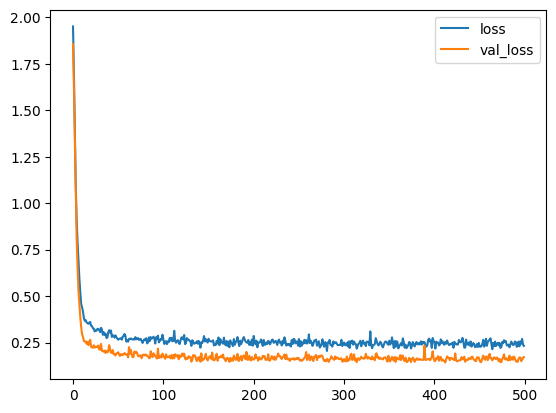

In [62]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

Displaying how the training and validation accuraccy changes over time.

<Axes: >

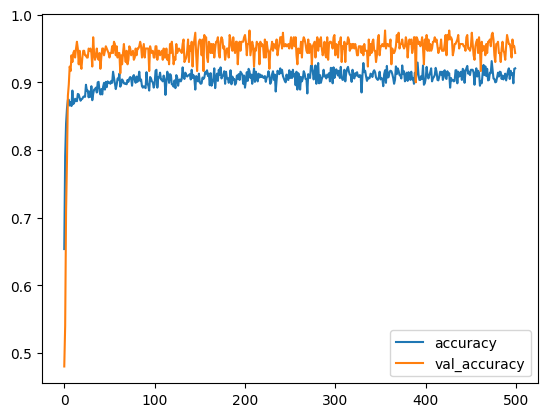

In [63]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [64]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.19403231143951416, 0.9266666769981384]

Train data evaluation:
[0.17807309329509735, 0.9471428394317627]


Predicting the the values using test data.

In [65]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
y_test = np.argmax(y_test, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


### Step 6: Metrics

The confusion matrix is a table used to evaluate the performance of a classification model by comparing the predicted classes to the actual classes in a dataset. It provides a detailed breakdown of correct and incorrect predictions with the numbers given in each square. It's like a heatmap, and most of our "heat" being in the main diagonal means successful results.

Text(50.72222222222221, 0.5, 'True values')

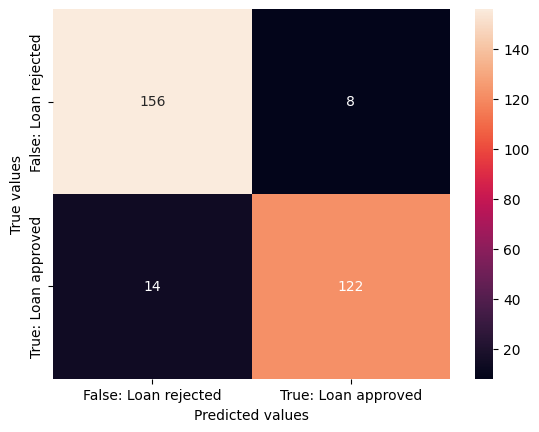

In [66]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted values')
plt.ylabel('True values')

We can see that it is doing quite well with over 92% total accuraccy.

In [67]:
print(classification_report(y_test, test_predictions, target_names=categories))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

                      precision    recall  f1-score   support

False: Loan rejected       0.92      0.95      0.93       164
 True: Loan approved       0.94      0.90      0.92       136

            accuracy                           0.93       300
           macro avg       0.93      0.92      0.93       300
        weighted avg       0.93      0.93      0.93       300


Model overall accuracy: 92.67%


An AUC score, ranging from 0 to 1 represents the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance. Standing at 0.99 it is a great result.

In [68]:
roc_auc_score(y, model.predict(X), multi_class="ovr")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


0.9920039295322822

### Step 7: Testing with made up values

First, I gave the input of a wealthy person with high credit score and long years of employment, which the model should easily predict as approved.

In [69]:
tester_row_approve = {
  'income' : 200000,
  'credit_score': 850,
  'loan_amount': 100000,
  'years_employed': 36, 
}

tester_row_approve = pd.DataFrame([tester_row_approve])
result = model.predict(tester_row_approve)[0]
result_text = categories[np.argmax(result)]

np.set_printoptions(precision=9, suppress=True)

print(f"Predicted result: {result_text}")
print()
print("Probabilities by class:")
print(categories)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted result: True: Loan approved

Probabilities by class:
['False: Loan rejected', 'True: Loan approved']
[0.00055991 0.99944013]


Next, I tried a poor individual with low credit score and little employment, the result should be not approved.

In [70]:
tester_row_approve = {
  'income' : 20000,
  'credit_score': 30,
  'loan_amount': 200000,
  'years_employed': 1, 
}

tester_row_approve = pd.DataFrame([tester_row_approve])
result = model.predict(tester_row_approve)[0]
result_text = categories[np.argmax(result)]

np.set_printoptions(precision=9, suppress=True)

print(f"Predicted result: {result_text}")
print()
print("Probabilities by class:")
print(categories)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted result: False: Loan rejected

Probabilities by class:
['False: Loan rejected', 'True: Loan approved']
[1.         0.00000004]


The tests resulted as expected, the model could predict them.

### Conclusion

This is a really simplistic dataset, works as expected. I have submitted it on the forum 3 days prior to when I started working on it, but unfortunately it is still awaiting approval. I hope it still satisfies the requirements.